In [2]:
import math
from astral import sun
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import numpy as np
from astropy.coordinates import Angle
from astropy import units as u
from astropy.io.votable import parse
from astropy.io import ascii
from astropy.table import Table
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
from astral import LocationInfo
import jupyter
from datetime import datetime, timedelta, timezone
from astropy.time import Time
import pytz


# globals
horizonBox = {  # {tuple(decWindow):tuple(minAlt,maxAlt)}
    (-35, -34): (-35, 42.6104),
    (-34, -32): (-35, 45.9539),
    (-32, -30): (-35, 48.9586),
    (-30, -28): (-35, 51.6945),
    (-28, -26): (-35, 54.2121),
    (-26, -24): (-35, 56.5487),
    (-24, -22): (-35, 58.7332),
    (-22, 0): (-35, 60),
    (0, 46): (-52.5, 60),
    (46, 56): (-37.5, 60),
    (56, 65): (-30, 60)
}

# dec_vertices = [item for key in horizonBox.keys() for item in key]  # this is just a list of integers, each being one member of one
dec_vertices = list(set([item for key in horizonBox.keys() for item in key]))  # this is just a list of integers, each being one member of one
# of the dec tuples that are the keys to the horizonBox dictionary
dec_vertices.sort()
locationInfo = LocationInfo(name="TMO", region="CA, USA",
                                        timezone="UTC",
                                        latitude=34.36,
                                        longitude=-117.63)

sidereal_rate = 360 / (23  * 3600 + 56 * 60 + 4.091)  # deg/second


def get_curent_sidereal_time():
    return Time(datetime.utcnow()).sidereal_time('mean', longitude=locationInfo.longitude)

# tmo observability functions (from maestro)
def siderealToDate(siderealAngle: Angle, current_sidereal_time: Angle):
    """!
    Convert an angle representing a sidereal time to UTC by relating it to local sidereal time
    @param siderealAngle: astropy Angle
    @param current_sidereal_time: the current sidereal time, also an astropy angle
    @return: datetime object, utc
    """
    # ---convert from sidereal to UTC---
    # find the difference between the sidereal observability start time and the sidereal start time of the program
    siderealFromStart = siderealAngle - current_sidereal_time
    # add that offset to the utc start time of the program (we know siderealStart is local sidereal time at startTime, so we use it as our reference)
    timeUTC = datetime.utcnow() + timedelta(
        hours=siderealFromStart.hour / 1.0027)  # one solar hour is 1.0027 sidereal hours

    return timeUTC

def dateToSidereal(dt: datetime, current_sidereal_time):
    timeDiff = dt - datetime.utcnow()
    sidereal_factor = 1.0027
    return current_sidereal_time + Angle(str(timeDiff.total_seconds()*sidereal_factor / 3600) + "h")

def toDecimal(angle: Angle):
    """!
    Return the decimal degree representation of an astropy Angle, as a float
    @return: Decimal degree representation, float
    """
    return round(float(angle.degree), 6)  # ew

def ensureFloat(angle):
    """!
    Return angle as a float, converting if necessary
    @rtype angle: float, Angle
    @return: decimal angle, as a float
    """
    try:
        if isinstance(angle, str) or isinstance(angle, tuple):
            angle = Angle(angle)
            return ensureFloat(angle)  # lol
    except:
        pass
    if isinstance(angle, float):
        return angle
    if isinstance(angle, Angle):
        return toDecimal(angle)
    else:
        return float(angle)

def getHourAngleLimits(dec):
    """
    Get the hour angle limits of the target's observability window based on its dec.
    @param dec: float, int, or astropy Angle
    @return: A tuple of Angle objects representing the upper and lower hour angle limits
    """
    dec = ensureFloat(dec)
    for decRange in horizonBox:
        if decRange[0] < dec <= decRange[1]:  # man this is miserable
            finalDecRange = horizonBox[decRange]
            return tuple([Angle(finalDecRange[0], unit=u.deg), Angle(finalDecRange[1], unit=u.deg)])
    return None


def ensureAngle(angle):
    """!
    Return angle as an astropy Angle, converting if necessary
    @param angle: float, int, hms Sexagesimal string, hms tuple, or astropy Angle
    @return: angle, as an astropy Angle
    """
    if not isinstance(angle, Angle):
        try:
            if isinstance(angle, str) or isinstance(angle, tuple):
                angle = Angle(angle)
            else:
                angle = Angle(angle, unit=u.deg)
        except Exception as err:
            print("Error converting", angle, "to angle")
            raise err
    return angle

def angleToTimedelta(angle: Angle):  # low precision
    """!
    Convert an astropy Angle to an timedelta whose duration matches the hourangle of the angle
    @rtype: timedelta
    """
    angleTime = angle.to(u.hourangle)
    angleHours, angleMinutes, angleSeconds = angleTime.hms
    return timedelta(hours=angleHours, minutes=angleMinutes, seconds=0)

def findTransitTime(rightAscension: Angle, location, target_dt=None, current_sidereal_time=None):
    """!Calculate the transit time of an object at the given location.

    @param rightAscension: The right ascension of the object as an astropy Angle
    @type rightAscension: Angle
    @param location: The observatory location.
    @type location: astral.LocationInfo
    @param target_dt: find the next transit after this time. if None, uses currentTime
    @param current_sidereal_time: the current sidereal time, as an astropy angle. will be calculated (slow) if not provided
    @return: The transit time of the object as a datetime object.
    @rtype: datetime.datetime
    """
    currentTime = datetime.utcnow().replace(second=0, microsecond=0)
    if current_sidereal_time is None:
        lst = Time(currentTime).sidereal_time('mean', longitude=location.longitude)
    else:
        lst = current_sidereal_time
    target_time = target_dt.replace(second=0, microsecond=0) or currentTime
    target_sidereal_time = dateToSidereal(target_time,lst)
    ha = Angle(wrap_around((rightAscension - target_sidereal_time).deg),unit=u.deg)
    transitTime = target_time + angleToTimedelta(ha)
    return transitTime

def staticObservabilityWindow(RA: Angle, Dec: Angle, locationInfo: LocationInfo, target_dt=None, current_sidereal_time=None):
    """!
    Generate the TMO observability window for a static target based on RA, dec, and location
    @param RA: right ascension
    @param Dec: declination
    @param locationInfo: astral LocationInfo object for the observatory site
    @param target_dt: find the next transit after this time. if None, uses currentTime
    @param current_sidereal_time: the current sidereal time. will add sidereal days to this if necessary
    @return: [startTime, endTime]
    @rtype: list(datetime)
    """
    if current_sidereal_time is None:
        currentTime = datetime.utcnow().replace(second=0, microsecond=0)
        lst = Time(datetime.utcnow()).sidereal_time('mean', longitude=locationInfo.longitude)
    target_dt = target_dt or datetime.utcnow()
    t = findTransitTime(ensureAngle(float(RA)), locationInfo, current_sidereal_time=current_sidereal_time,target_dt=target_dt)
    timeWindow = (angleToTimedelta(a) for a in getHourAngleLimits(Dec))
    return [t + a for a in timeWindow]
    # HA = ST - RA -> ST = HA + RA


def wrap_around(value):
    a = -180
    b = 180
    return (value - a) % (b-a) + a

# get hour angle, in
def get_hour_angle(ra,dt,current_sidereal_time):
    sidereal = dateToSidereal(dt,current_sidereal_time)
    return Angle(wrap_around((sidereal-ra).deg),unit=u.deg)

def julianToDatetime(hjd):
    time = Time(hjd, format='jd', scale='tdb')
    return time.to_datetime()

def datetimeToJulian(datetime):
  return Time(datetime).jd

def jdToStringFormat(value):
    dt = julianToDatetime(value)
    return dt.strftime("%H:%M %D")

def jdAxisFormat(value, tickNumber):
    return jdToStringFormat(value).replace(" ","\n")

def getSunriseSunset(dt=datetime.utcnow(), jd=False):
    """!
    get sunrise and sunset for TMO
    @return: sunriseUTC, sunsetUTC
    @rtype: datetime.datetime
    """
    dt = pytz.UTC.localize(dt)
    s = sun.sun(locationInfo.observer, date=dt, tzinfo=timezone.utc)
    sunriseUTC = s["sunrise"]
    sunsetUTC = sun.time_at_elevation(locationInfo.observer, -10, direction=sun.SunDirection.SETTING,date=dt)

    # TODO: make this less questionable - it probably doesn't do exactly what i want it to when run at certain times of the day:
    if sunriseUTC < dt:  # if the sunrise we found is earlier than the current time, add one day to it (approximation ofc)
        sunriseUTC = sunriseUTC + timedelta(days=1)

    if sunsetUTC > sunriseUTC:
        sunsetUTC = sunsetUTC - timedelta(days=1)

    if jd:
        sunriseUTC, sunsetUTC = datetimeToJulian(sunriseUTC), datetimeToJulian(sunsetUTC)
    return sunriseUTC, sunsetUTC


def get_RA_window(current_sidereal_time, target_dt, dec, ra=None):
    # get the bounding RA coordinates of the TMO observability window for time target_dt for targets at declination dec. Optionally, input an RA to also get out that RA, adjusted for box-shifting

    adjusted_ra = ra.copy() if ra is not None else None
    hourAngleWindow = getHourAngleLimits(dec)
    if not hourAngleWindow: return False
    raWindow = [dateToSidereal(target_dt, current_sidereal_time) - hourAngleWindow[1],
                (dateToSidereal(target_dt, current_sidereal_time) - hourAngleWindow[0]) % Angle(360, unit=u.deg)]

    # we want something like (23h to 17h) to look like [(23h to 24h) or (0h to 17h)] so we move the whole window to start at 0 instead
    if raWindow[0] > raWindow[1]:
        diff = Angle(24, unit=u.hour) - raWindow[0]
        raWindow[1] += diff
        if adjusted_ra is not None:
            adjusted_ra = (adjusted_ra + diff) % Angle(360, unit=u.deg)
        raWindow[0] = Angle(0, unit=u.deg)
    return raWindow, adjusted_ra


def observationViable(dt: datetime, ra: Angle, dec: Angle, current_sidereal_time=None,locationInfo=None):
    """
    Can a target with RA ra and Dec dec be observed at time dt? Checks hour angle limits based on TMO bounding box.
    @return: bool
    """
    if current_sidereal_time is None:
        current_sidereal_time = Time(datetime.utcnow()).sidereal_time('mean', longitude=locationInfo.longitude)
    HA_window = getHourAngleLimits(dec)
    HA = get_hour_angle(ra,dt,current_sidereal_time)
    # NOTE THE ORDER:
    return HA.is_within_bounds(HA_window[0], HA_window[1])


# def observationViable(dt: datetime, ra: Angle, dec: Angle, current_sidereal_time=None,locationInfo=None):
#     """
#     Can a target with RA ra and Dec dec be observed at time dt? Checks hour angle limits based on TMO bounding box.
#     @return: bool
#     """
#     if current_sidereal_time is None:
#         current_sidereal_time = Time(datetime.utcnow()).sidereal_time('mean', longitude=locationInfo.longitude)
#     raWindow, rac = get_RA_window(current_sidereal_time,dt,dec,ra=ra)
#     # NOTE THE ORDER:
#     return rac.is_within_bounds(raWindow[0], raWindow[1])

In [3]:
epoch = 2460257
num_day_forecast = 60
alltimes = np.linspace(epoch,epoch+num_day_forecast,num=num_day_forecast*60*24)
christ_period = 0.3439788

In [4]:
lc = pd.read_csv("all_phot_2023_11_19-22.csv")
lc["times"] = pd.to_datetime(lc["timestamp"],format="%Y-%m-%dT%H:%M:%S.0000")
lc["julian"] = [datetimeToJulian(t) for t in lc["times"]]
# for centering
middle_idx = lc[lc["times"]==lc["times"].median()].index[0]

# lc["phase"] = [phi(t=t) for t in lc["julian"]]
lc = lc.sort_values(by="julian")
lc.to_csv("target_jd_photometry.csv",index=None)

/tmp/ipykernel_740/2715222376.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  lc = pd.read_csv("all_phot_2023_11_19-22.csv")


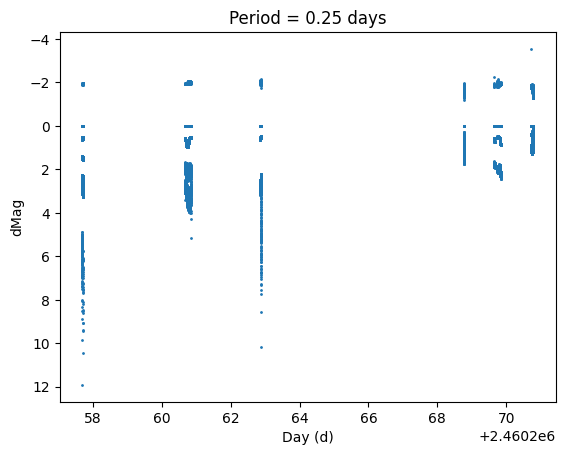

In [5]:
fig, ax = plt.subplots()
mag_col = "dmag_6"
ap_idx = 6
p = 0.25
ax.set_title(f"Period = {round(p,2)} days")
ax.set_xlabel("Day (d)")
ax.set_ylabel("dMag")
# ax.set_xlim(0,p)
ax.scatter(lc["julian"],lc[mag_col],s=1)
plt.gca().invert_yaxis()
plt.show()

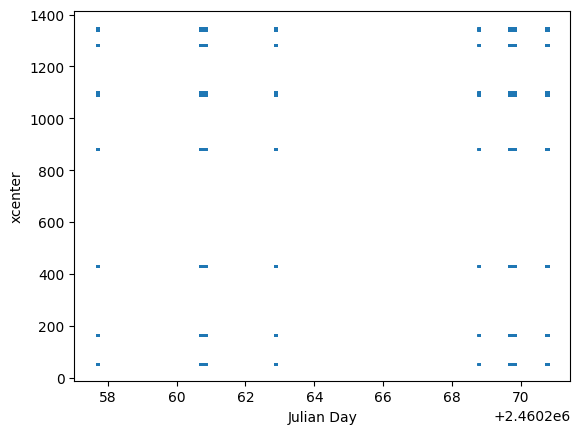

52.43553590580135 1348.5271338100863
46.22130171014145 1146.8191738741305


In [6]:
fig, ax = plt.subplots()
ax.set_xlabel("Julian Day")
ax.set_ylabel("xcenter")
# ax.set_xlim(0,p)
ax.scatter(lc["julian"],lc["xcenter"],s=1)
# plt.gca().invert_yaxis()
plt.show()
print(min(lc["xcenter"]),max(lc["xcenter"]))
print(min(lc["ycenter"]),max(lc["ycenter"]))

In [62]:
lc.to_csv("problem_photometry.csv",index=None)

In [7]:
# using many different stars as references
referenceStars = [1,2,4,5,6,7,8,9]
_NN_apertures = 8
refmags = []
dmags = {}
for ref_star in referenceStars:
    for ap_num in range(_NN_apertures):
        mag_title = f'mag_{ap_num}' 
        refmag_title = f'refmag_{ref_star}_{ap_num}'
        dmag_title = f'dmag_{ref_star}_{ap_num}'  
        if ap_num not in dmags.keys():
            dmags[ap_num] = [dmag_title]
        else:
            dmags[ap_num].append(dmag_title)
        # print((lc['id']))
        # print(mag_title,dmag_title,lc[lc['id']==np.float64(ref_star)][mag_title])
        lc[refmag_title]=lc[lc['id']==ref_star][mag_title]
        lc[refmag_title].fillna(method='ffill', inplace=True)
        lc[refmag_title].fillna(method='bfill', inplace=True)

        lc[dmag_title]=lc[mag_title]-lc[refmag_title]
print(dmags)

/tmp/ipykernel_740/1148364182.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lc[refmag_title].fillna(method='ffill', inplace=True)
/tmp/ipykernel_740/1148364182.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lc[refmag_title].fillna(method='bfill', inplace=True)
/tmp/ipykernel_740/1148364182.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lc[refmag_title].fillna(method='ffill', inplace=True)
/tmp/ipykernel_740/1148364182.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lc[refmag_title].fillna(method='bfill', inplace=True)
/tmp/ipykernel_740/1148364182.py:18: FutureWarning: Series.fillna with 'method' is deprecated an

{0: ['dmag_1_0', 'dmag_2_0', 'dmag_4_0', 'dmag_5_0', 'dmag_6_0', 'dmag_7_0', 'dmag_8_0', 'dmag_9_0'], 1: ['dmag_1_1', 'dmag_2_1', 'dmag_4_1', 'dmag_5_1', 'dmag_6_1', 'dmag_7_1', 'dmag_8_1', 'dmag_9_1'], 2: ['dmag_1_2', 'dmag_2_2', 'dmag_4_2', 'dmag_5_2', 'dmag_6_2', 'dmag_7_2', 'dmag_8_2', 'dmag_9_2'], 3: ['dmag_1_3', 'dmag_2_3', 'dmag_4_3', 'dmag_5_3', 'dmag_6_3', 'dmag_7_3', 'dmag_8_3', 'dmag_9_3'], 4: ['dmag_1_4', 'dmag_2_4', 'dmag_4_4', 'dmag_5_4', 'dmag_6_4', 'dmag_7_4', 'dmag_8_4', 'dmag_9_4'], 5: ['dmag_1_5', 'dmag_2_5', 'dmag_4_5', 'dmag_5_5', 'dmag_6_5', 'dmag_7_5', 'dmag_8_5', 'dmag_9_5'], 6: ['dmag_1_6', 'dmag_2_6', 'dmag_4_6', 'dmag_5_6', 'dmag_6_6', 'dmag_7_6', 'dmag_8_6', 'dmag_9_6'], 7: ['dmag_1_7', 'dmag_2_7', 'dmag_4_7', 'dmag_5_7', 'dmag_6_7', 'dmag_7_7', 'dmag_8_7', 'dmag_9_7']}


/tmp/ipykernel_740/1148364182.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  lc[refmag_title]=lc[lc['id']==ref_star][mag_title]
/tmp/ipykernel_740/1148364182.py:18: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lc[refmag_title].fillna(method='ffill', inplace=True)
/tmp/ipykernel_740/1148364182.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  lc[refmag_title].fillna(method='bfill', inplace=True)
/tmp/ipykernel_740/1148364182.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance

In [8]:
import os
for aperture in [0,1,2,3,4,5,6,7]:
    if not os.path.exists(f"plots/aperture_{aperture}"):
        os.mkdir(f"plots/aperture_{aperture}")
    savepath = f"plots/aperture_{aperture}"
    for dmag_col in dmags[aperture]:
        targLc = lc[lc['id']==3]
        targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
        print(middle_idx)
        middle_p = p/2
        middle_jul = lc.iloc[middle_idx]["julian"]
        offset = middle_p - middle_jul%p

        targLc.set_index('dt', inplace=True)

        binned_data = targLc[dmag_col].resample('1T').median()

        binned_data = binned_data.reset_index()

        binned_data['dt'] = binned_data['dt'].apply(lambda x: x.to_julian_date())
        binned_data['dt'] = (binned_data['dt'] + offset)% (christ_period)

        plt.scatter(binned_data['dt'], binned_data[dmag_col], c="blue", alpha=0.5, s=1)
        plt.title(f"Aperture {aperture}, Ref Star {dmag_col[5]}")
        plt.savefig(f"{savepath}/{dmag_col[5]}.png")
        plt.clf()

/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310
19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

19310
19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

19310
19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

19310
19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

19310
19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

19310
19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


/tmp/ipykernel_740/3446307920.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')
/tmp/ipykernel_740/3446307920.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  targLc['dt'] = pd.to_datetime(lc['julian'], origin='julian', unit='D')


19310


<Figure size 640x480 with 0 Axes>

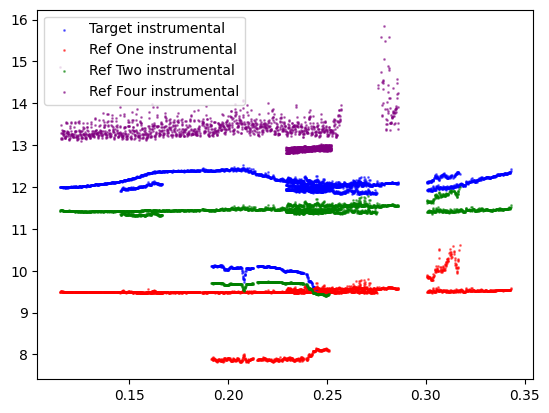

In [9]:
targLc = lc[lc['id']==3]
plt.scatter(targLc['julian']%christ_period, targLc['mag_6'], c="blue", alpha=0.5, s=1,label="Target instrumental")

refOne = lc[lc["id"]==1]
plt.scatter(refOne['julian']%christ_period, refOne['mag_6'], c="red", alpha=0.5, s=1,label="Ref One instrumental")
refTwo = lc[lc["id"]==2]
plt.scatter(refTwo['julian']%christ_period, refTwo['mag_6'], c="green", alpha=0.5, s=1,label="Ref Two instrumental")
refFour = lc[lc["id"]==4]
plt.scatter(refFour['julian']%christ_period, refFour['mag_6'], c="purple", alpha=0.5, s=1,label="Ref Four instrumental")


# plt.ylim(0,23)

plt.legend()
plt.show()


/tmp/ipykernel_47993/2869186170.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  s = ax.scatter((day_data["julian"]+offset)%p,day_data["dmag_5"],label=day,s=1,c=colors[i],alpha=0.5)
/tmp/ipykernel_47993/2869186170.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  s = ax.scatter((day_data["julian"]+offset)%p,day_data["dmag_5"],label=day,s=1,c=colors[i],alpha=0.5)
/tmp/ipykernel_47993/2869186170.py:31: UserWarning: *c* 

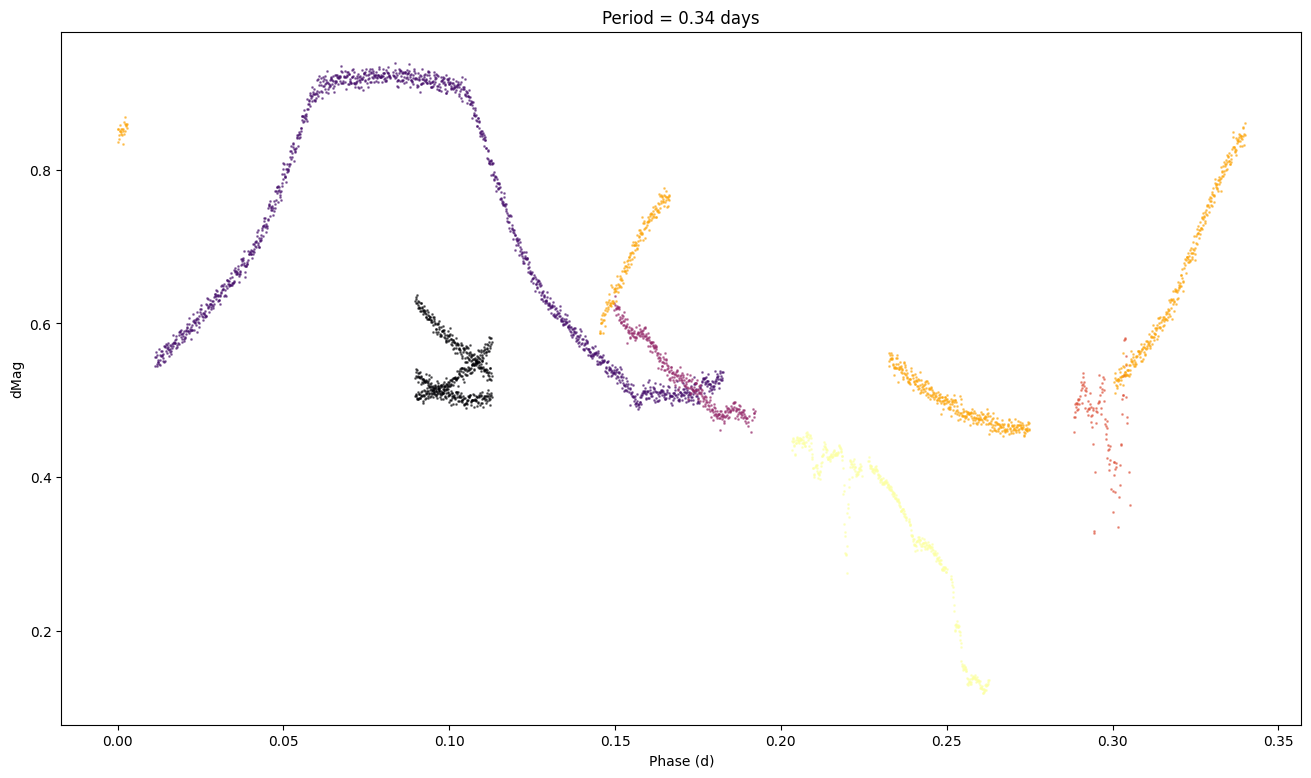

In [49]:
plt.rcParams['animation.embed_limit'] = 200

min_time = min(lc["julian"])
max_time = max(lc["julian"])
window = (min_time,max_time)

fig, ax = plt.subplots(figsize=(16,9))

index_range = np.where(np.logical_and(min_time <= alltimes, alltimes<max_time))[0]
p2 = 0.73*christ_period

days = [int(i) for i in lc["julian"]]
colors = list(plt.cm.inferno(np.linspace(0,1,len(np.unique(days)))))

lower = 0.34
upper = 0.35
num_frames = 450

def update(frame):
    i = 0
    p = frame*(upper-lower)/num_frames + lower
    ax.cla()
    middle_p = p/2
    middle_jul = lc.iloc[middle_idx]["julian"]
    offset = middle_p - middle_jul%p
    ax.set_title(f"Period = {round(p,5)} days")
    ax.set_xlabel("Phase (d)")
    ax.set_ylabel("dMag")
    for day in np.unique(days):
        day_data = lc[lc["julian"].astype(int)==day]
        s = ax.scatter((day_data["julian"]+offset)%p,day_data["dmag_5"],label=day,s=1,c=colors[i],alpha=0.5)
        i+=1
    # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # s = ax.scatter((lc["julian"]+offset)%p,lc["dmag_5"],c=lc["julian"], s=1,cmap="inferno")
    return [s]

ani = animation.FuncAnimation(fig=fig, func=update, frames=num_frames, interval=75, repeat=True)
html_ani = ani.to_jshtml()
with open("constrained_period_4.html","w") as f:
    f.write(html_ani)

# ani.save(filename=f"folding.gif", writer="pillow")

/tmp/ipykernel_740/199456203.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(day_data["julian"]%christ_period,day_data["dmag_5"],label=day,s=1,c=colors.pop())
/tmp/ipykernel_740/199456203.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(day_data["julian"]%christ_period,day_data["dmag_5"],label=day,s=1,c=colors.pop())
/tmp/ipykernel_740/199456203.py:7: UserWarning: *c* argument looks like a single

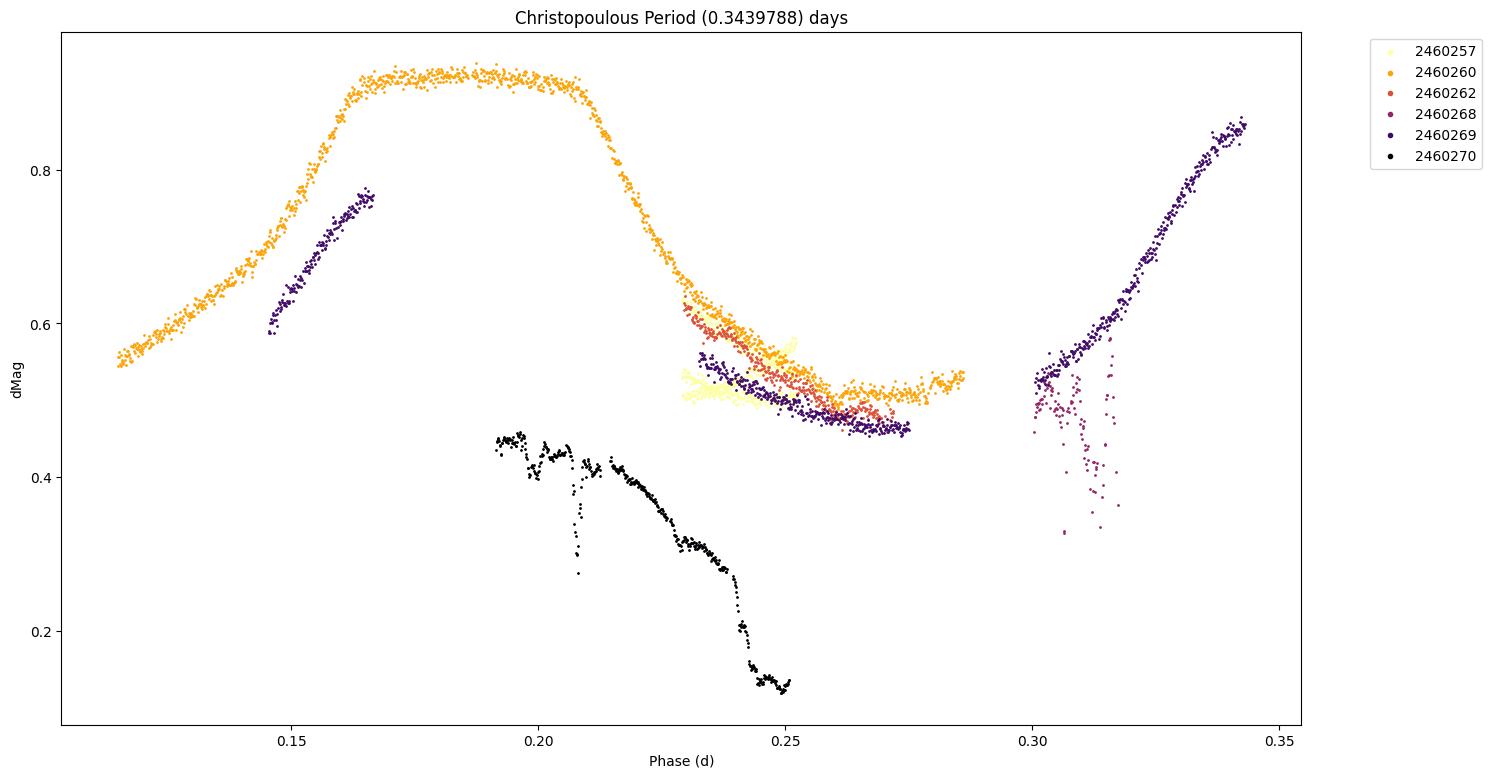

In [12]:
# loop through the unique integer julian days in the dataset and plot the data for each day, each with a label and in a different color.
days = [int(i) for i in targLc["julian"]]
fig, ax = plt.subplots(figsize=(16,9))
colors = list(plt.cm.inferno(np.linspace(0,1,len(np.unique(days)))))
for day in np.unique(days):
    day_data = targLc[targLc["julian"].astype(int)==day]
    ax.scatter(day_data["julian"]%christ_period,day_data["dmag_5"],label=day,s=1,c=colors.pop())
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', markerscale=3)
ax.set_xlabel("Phase (d)")
ax.set_ylabel("dMag")
ax.set_title("Christopoulous Period (0.3439788) days")
plt.savefig("christopoulous_period.png",dpi=300,bbox_inches="tight")
plt.show()